## Emulator covariance matrix

In the current emulator set-up, we constructur our emulator covariance matrix assuming a maximum correlation of the errors bewteen $k$ bins. In this notebook I will use the leave-one-out test to get some estimation of how correlated the errors are in practice by calculating the quantity:

$$C_{ij}=\langle (P_\mathrm{emu}(k_i)-P_\mathrm{true}(k_i))(P_\mathrm{emu}(k_j)-P_\mathrm{true}(k_j)) \rangle$$

by iterating over the entire suite of 30 Australia20 simulations.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# our own modules
import gp_emulator
import p1d_arxiv

In [10]:
font = {'size'   : 11}

matplotlib.rc('font', **font)

In [3]:
skewers_label='Ns500_wM0.05'
p1d_label=None
kmax_Mpc=8
basedir="/p1d_emulator/sim_suites/Australia20/"

In [4]:
set_k=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=4,pick_sim_number=0,
                            drop_temp_rescalings=True,skewers_label=skewers_label)
## Set up k bins for emulator call
k_test=set_k.data[1]["k_Mpc"][1:]
k_test=k_test[k_test<8]

In [5]:
def leave_one_out_covmat(z_test):
    """ This function aims to measure the emulator covariance. We will calculate:
        < (P_i-P_i_true)(P_j-P_j_true) >
        
        where each i,j represent a k bin. We want to see how correlated errors
        in different k bins are. We do this by iterating over our sim suite via the
        leave one out test as in the emulator validation tests
        """
    
    ## Data arrays
    fractional_error=np.empty((30,9,len(k_test)))
    theory_error=np.empty((30,9,len(k_test)))
    
    cov_mat=np.zeros((len(k_test),len(k_test)))


    for simnum in range(0,30):
        truth=p1d_arxiv.ArxivP1D(basedir=basedir,
                                drop_tau_rescalings=True,z_max=4,pick_sim_number=simnum,
                                drop_temp_rescalings=True,skewers_label=skewers_label)
        training=p1d_arxiv.ArxivP1D(basedir=basedir,
                                drop_tau_rescalings=True,z_max=4,drop_sim_number=simnum,
                                drop_temp_rescalings=True,skewers_label=skewers_label)
                            
        
        emu_test=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=4,
                                verbose=False,paramList=None,train=False,
                                emu_type="k_bin",passArxiv=training,
                                drop_tau_rescalings=True,checkHulls=False,
                                drop_temp_rescalings=True)
        emu_test.load_default()
        
        for aa,item in enumerate(truth.data):
            if item["z"]!=z_test:
                continue
            else:
                emu_call={}
                for bb,param in enumerate(emu_test.paramList):
                    emu_call[param]=item[param]

                pred,err=emu_test.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
                
                for aa in range(len(pred)):
                    for bb in range(len(pred)):
                        cov_mat[aa][bb]=cov_mat[aa][bb]+(pred[aa]-item["p1d_Mpc"][aa+1])*(pred[bb]-item["p1d_Mpc"][bb+1])

    cov_mat*=(1./30)
    return cov_mat

In [7]:
cov2=leave_one_out_covmat(2)
cov25=leave_one_out_covmat(2.5)
cov3=leave_one_out_covmat(3)
cov35=leave_one_out_covmat(3.5)
cov4=leave_one_out_covmat(4)

 /home/chris/.local/lib/python3.5/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


It is easier to see correlations using the correlation matrix instead, so from $C_{ij}$ defined above we instead plot

$$C^\mathrm{corr}_{ij}=\frac{C_{ij}}{\sqrt{C_{ii}C_{jj}}}$$

In [6]:
def cov_to_correlation(matrix):
    """ From a covariance matrix, calculate
    a correlation matrix """
    
    corr=np.zeros((len(matrix),len(matrix)))
    for aa in range(len(matrix)):
        for bb in range(len(matrix)):
            corr[aa][bb]=matrix[aa][bb]/(np.sqrt(matrix[aa][aa]*matrix[bb][bb]))
    return corr

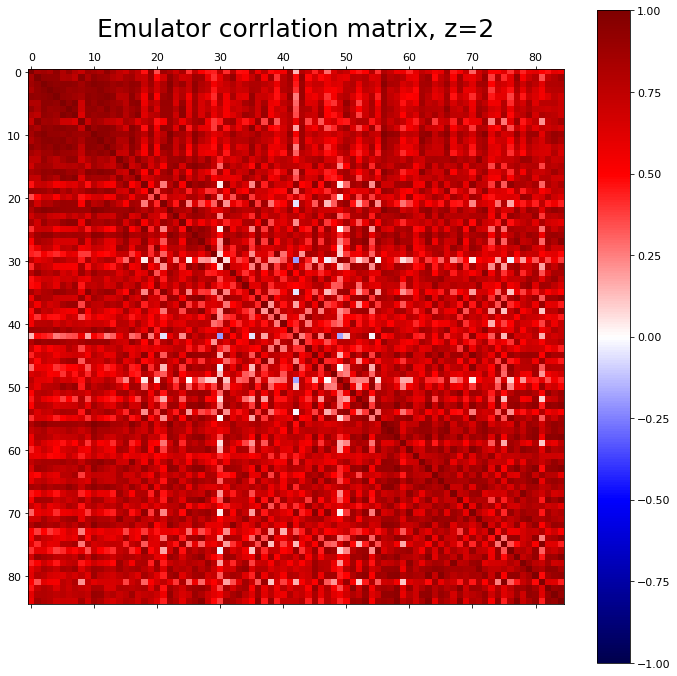

In [12]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
cax=ax.matshow(cov_to_correlation(cov2),cmap=matplotlib.cm.seismic,norm=norm)
plt.title("Emulator corrlation matrix, z=2",fontsize=25)
cbar=fig.colorbar(cax)
cbar.set_clim(-1,1)

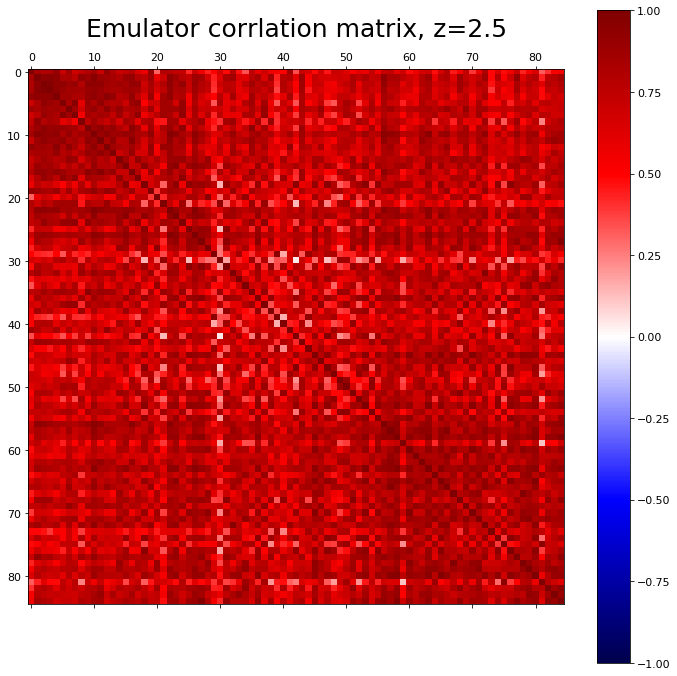

In [13]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
cax=ax.matshow(cov_to_correlation(cov25),cmap=matplotlib.cm.seismic,norm=norm)
plt.title("Emulator corrlation matrix, z=2.5",fontsize=25)
cbar=fig.colorbar(cax)
cbar.set_clim(-1,1)

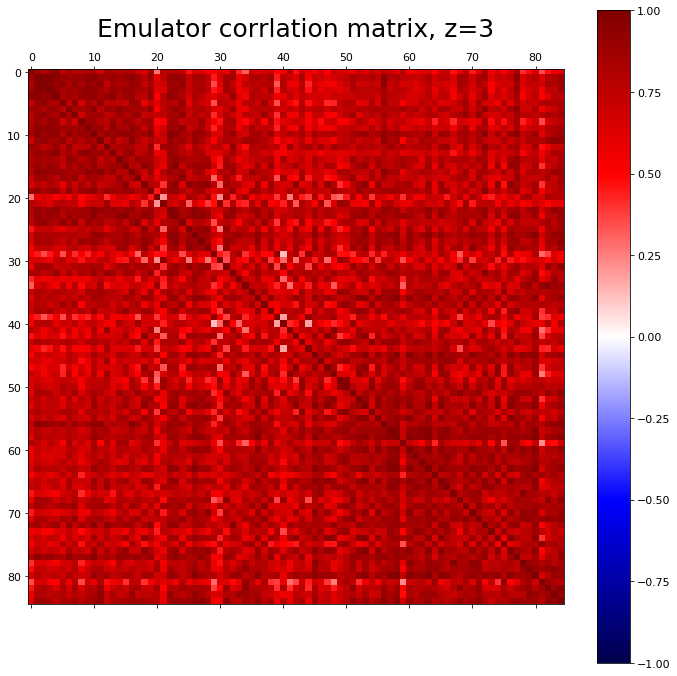

In [14]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
cax=ax.matshow(cov_to_correlation(cov3),cmap=matplotlib.cm.seismic,norm=norm)
plt.title("Emulator corrlation matrix, z=3",fontsize=25)
cbar=fig.colorbar(cax)
cbar.set_clim(-1,1)

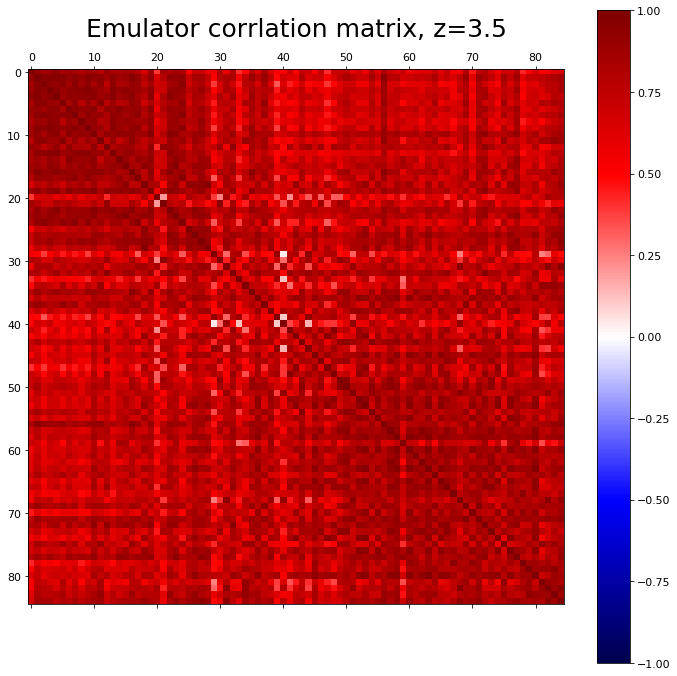

In [15]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
cax=ax.matshow(cov_to_correlation(cov35),cmap=matplotlib.cm.seismic,norm=norm)
plt.title("Emulator corrlation matrix, z=3.5",fontsize=25)
cbar=fig.colorbar(cax)
cbar.set_clim(-1,1)

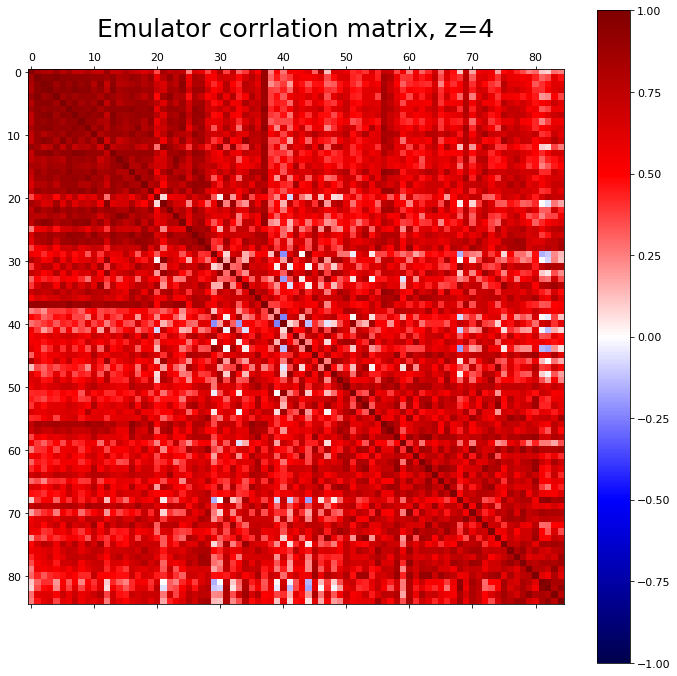

In [16]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
cax=ax.matshow(cov_to_correlation(cov4),cmap=matplotlib.cm.seismic,norm=norm)
plt.title("Emulator corrlation matrix, z=4",fontsize=25)
cbar=fig.colorbar(cax)
cbar.set_clim(-1,1)

The approximation of assuming maximally correlated errors is equivalent to having a correlation matrix where every entry is 1. I think overall this is a fair approximation after looking at these results. Particularly at intermediate $z$ the errors are highly correlated. In the $z=4$ plot we see some spots of anti-correlation but the effects of this would be negligible.